# Setting up pyspark

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!tar -xzvf /content/drive/MyDrive/spark-3.3.2-bin-hadoop3.tgz

spark-3.3.2-bin-hadoop3/
spark-3.3.2-bin-hadoop3/LICENSE
spark-3.3.2-bin-hadoop3/NOTICE
spark-3.3.2-bin-hadoop3/R/
spark-3.3.2-bin-hadoop3/R/lib/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.2-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/hsearch.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/links.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/nsInfo.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/package.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/vignette.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/NAMESPACE
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/SparkR
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/SparkR.rdb
spark-3.3.2-bin-hadoop3/R/lib/SparkR/R/SparkR.rdx
spark-3.3.2-bin-hadoop3/R/lib/SparkR/doc/
spark-3.3.2-bin-hadoop3/R/lib/Spar

In [7]:
ls /content/spark-3.3.2-bin-hadoop3

bin/   data/      jars/        LICENSE    NOTICE   R/         RELEASE  yarn/
conf/  examples/  kubernetes/  licenses/  python/  README.md  sbin/


In [8]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import os

In [10]:
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

In [11]:
import findspark
findspark.init()

# Import modules and create spark session

In [13]:
# create spark context 
from pyspark import SparkContext
sc = SparkContext(master = "local")
                  
# initialize the Spark Session
from pyspark.sql import SparkSession

#create Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sentiment Analysis in pySpark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Reading Data file into Spark DataFrame

In [14]:
# --- reading data via Spark
df = spark.read.csv("/content/drive/MyDrive/Untitledfolder/Tweets.csv", inferSchema = True, header = True, sep=",")
df.printSchema()


root
 |-- tweet_id: string (nullable = true)
 |-- airline_sentiment: string (nullable = true)
 |-- airline_sentiment_confidence: string (nullable = true)
 |-- negativereason: string (nullable = true)
 |-- negativereason_confidence: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- airline_sentiment_gold: string (nullable = true)
 |-- name: string (nullable = true)
 |-- negativereason_gold: string (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- tweet_coord: string (nullable = true)
 |-- tweet_created: string (nullable = true)
 |-- tweet_location: string (nullable = true)
 |-- user_timezone: string (nullable = true)



In [15]:
df.head(3)

[Row(tweet_id='570306133677760513', airline_sentiment='neutral', airline_sentiment_confidence='1.0', negativereason=None, negativereason_confidence=None, airline='Virgin America', airline_sentiment_gold=None, name='cairdin', negativereason_gold=None, retweet_count=0, text='@VirginAmerica What @dhepburn said.', tweet_coord=None, tweet_created='2015-02-24 11:35:52 -0800', tweet_location=None, user_timezone='Eastern Time (US & Canada)'),
 Row(tweet_id='570301130888122368', airline_sentiment='positive', airline_sentiment_confidence='0.3486', negativereason=None, negativereason_confidence='0.0', airline='Virgin America', airline_sentiment_gold=None, name='jnardino', negativereason_gold=None, retweet_count=0, text="@VirginAmerica plus you've added commercials to the experience... tacky.", tweet_coord=None, tweet_created='2015-02-24 11:15:59 -0800', tweet_location=None, user_timezone='Pacific Time (US & Canada)'),
 Row(tweet_id='570301083672813571', airline_sentiment='neutral', airline_sentim

In [16]:
df = df.na.drop(subset=["airline_sentiment","airline","text"])

In [17]:
from pyspark.sql.functions import col, expr, when
df = df.withColumn('airline_sentiment', when(col('airline_sentiment')=='positive', 2)
                .when(col('airline_sentiment')=='negative',0)
              .otherwise(1))


# Select the related data

In [18]:
# --- select only "text" and "airline_sentiment" column, 
# --- and cast "airline_sentiment" column data into integer
data = df.select(col("airline_sentiment").cast("Int").alias("label"),"text")
data.show(truncate = False,n=5)

+-----+----------------------------------------------------------------------------------------------------------------------------------+
|label|text                                                                                                                              |
+-----+----------------------------------------------------------------------------------------------------------------------------------+
|1    |@VirginAmerica What @dhepburn said.                                                                                               |
|2    |@VirginAmerica plus you've added commercials to the experience... tacky.                                                          |
|1    |@VirginAmerica I didn't today... Must mean I need to take another trip!                                                           |
|0    |"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"|
|0    |@VirginAmerica and i

In [19]:
data.printSchema()

root
 |-- label: integer (nullable = false)
 |-- text: string (nullable = true)



# Divided the data into training and testing

In [27]:
# #divide data, 70% for training, 30% for testing
dividedData = data.randomSplit([0.7, 0.3]) 
trainingData = dividedData[0] #index 0 = data training
testingData = dividedData[1] #index 1 = data testing

In [30]:
trainingData.write.csv('train.csv')

In [31]:
testingData.write.csv('test.csv')

# Importing required libraries

In [32]:
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.feature import ChiSqSelector

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import os, tempfile
import csv
import string
import random

# Data Cleaning

In [33]:
# --- function to remove stop words
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

# --- function to handle numbers, single characters URL's and @Username
# --- Cleaning data

def clean(filename):
    text=open(filename, encoding='ISO-8859-1')
    file_reader = csv.reader(text)
    clean_final=[]
    c=0
    stop=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 
          'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 
          'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 
          'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 
          'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 
          'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
          'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
          'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
          'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
          'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should',
          'now']
    shuffle=[]
    tweet_list=[]
    for row in file_reader:
        temp_t=row[1]
        ts=temp_t.split(" ")
        for w in range(1,len(ts)):
            ts[w]=ts[w].lower()
            if (ts[w]!='' and ts[w][0]=='@'):
                ts[w]='AT_USER'
            if (ts[w]!='' and len(ts[w])>4  and ts[w][0]=='w' and ts[w][1]=='w' and ts[w][2]=='w' and ts[w][3]=='.'):
                ts[w]='URL'
            if (ts[w]!='' and len(ts[w])>7  and ts[w][0]=='h' and ts[w][1]=='t' and ts[w][2]=='t' and ts[w][3]=='p' and
                ts[w][4]==':' and ts[w][5]=='/' and ts[w][6]=='/'):
                ts[w]='URL'
            if (ts[w]!='' and len(ts[w])>8  and ts[w][0]=='h' and ts[w][1]=='t' and ts[w][2]=='t' and ts[w][3]=='p' and
                ts[w][4]=='s' and ts[w][5]==':' and ts[w][6]=='/' and ts[w][7]=='/'):
                ts[w]='URL'
            for i in range(0,len(ts[w])):
                flag=0
                if len(ts[w])>i+2 and ts[w][i]==ts[w][i+1] and ts[w][i]==ts[w][i+2]:
                    for j in range(i+2,len(ts[w])):
                        if ts[w][i]==ts[w][j]:
                            flag=1
                            if len(ts[w])>j+1 and ts[w][i]!=ts[w][j+1]:
                                break
                        if j==(len(ts[w]))-1 and ts[w][i]==ts[w][j]:
                            flag=1
                            break
                    if flag==1:
                        ts[w]=ts[w].replace(ts[w][i:j+1],ts[w][i])
            if (ts[w]!='' and ts[w][0].isdigit()):
                ts[w]=''
        for i in range(0,len(stop)):
            if stop[i] in ts:
                ts = remove_values_from_list(ts, stop[i])
        cleaned_list=[word.strip(string.punctuation) for word in ts]
        while '' in cleaned_list:
            cleaned_list.remove('')
        clean_final.append(cleaned_list)
        shuffle.append([row[0],cleaned_list])
        tweet_list.append(row[1])
    return (shuffle,tweet_list)

### Processed data for training 

In [37]:
train_shuffle,train_tweet_list=clean("/content/train.csv/part-00000-89374d7d-429c-4f2e-a3c9-527b25b09548-c000.csv")

### Processed data for testing 

In [38]:
test_shuffle,test_tweet_list=clean("/content/test.csv/part-00000-9b5c86d0-14e5-43e5-a08e-6bccb09f2b8f-c000.csv")

## TF-IDF functions 

In [39]:
# --- Compute TF
# --- The HashingTF that is the term frequency is computed for a feature space of 25000 and 50000
def CompTF(tshuffle_rdd):
    t_rdd=sc.parallelize([row[1] for row in tshuffle_rdd.collect()])
    hashingTF = HashingTF(100000)
    tf = hashingTF.transform(t_rdd)
    return tf
# --- the HashingTF that is the term frequency is computed for a feature space of 1500 and 3000 for Decision Tree
def CompTF_withNumFeatures(tshuffle_rdd):
    t_rdd=sc.parallelize([row[1] for row in tshuffle_rdd.collect()])
    hashingTF = HashingTF(6000)
    tf = hashingTF.transform(t_rdd)
    return tf
# --- Compute IDF
# --- The IDF() computes the Inverse document frequency
def CompIDF(tf):
    tf.cache()
    idf = IDF().fit(tf)
    return idf
#Compute TFIDF
def CompTFIDF(tf,idf):
    tfidf = idf.transform(tf)
    return tfidf


In [40]:
# --- Feature Extraction
# --- Converts a pair of labels and features into a Labeled Point
def Convert_to_LabeledPoint(labels,features):
    training = labels.zip(features).map(lambda x: LabeledPoint(x[0], x[1]))
    return training

## Training Algorithms 

In [41]:
# --- Naive Bayes
#Training - NB
def NB_train(training):
    model = NaiveBayes.train(training)
    return model

# --- Logistic Regression
#Training - LG
def LG_train(training):
    model = LogisticRegressionWithLBFGS.train(training,numClasses=3)
    return model


# --- Decision Trees
#Training - DT
def DT_train(training):
    model = DecisionTree.trainClassifier(training, numClasses=3, categoricalFeaturesInfo={},
                                        impurity='gini', maxDepth=5, maxBins=32)
    return model

### Testing functions 

In [42]:
# --- Testing
# --- Predicts labels based on the given features
def test(model,labels,features):
    labels_and_preds = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "predicted": float(x[1])})
    acc=100.0*((labels_and_preds.filter(lambda x:x["actual"]==x["predicted"]).count()) / (labels.count()))
    return acc

# --- Testing with pred prob
# -- Predicts labels based on the given features and also returns the set of predicts probabilities
# -- (Only for Logistic Regression)
def test_wpp(model,labels,features):
    labels_and_probs = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "probs": float(x[1])})
    return labels_and_probs
    
# --- Final Testing
# --- Predicts labels based on the given features and returns predicted labels also for the purpose of calculation
def test_final(model,labels,features):
    labels_and_preds = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "predicted": float(x[1])})
    acc=100.0*((labels_and_preds.filter(lambda x:x["actual"]==x["predicted"]).count()) / (labels.count()))
    return (labels_and_preds,acc)


In [43]:
# --- True positive rate and false positive rate
def tf(labels_and_preds):
    true_pos = (labels_and_preds.filter(lambda x:x["predicted"]==1 and x["actual"]==1).count())
    true_neg = (labels_and_preds.filter(lambda x:x["predicted"]==0 and x["actual"]==0).count())
    false_pos = (labels_and_preds.filter(lambda x:x["predicted"]==1 and x["actual"]==0).count())
    false_neg = (labels_and_preds.filter(lambda x:x["predicted"]==0 and x["actual"]==1).count())

    tpr=(true_pos)/(true_pos+false_neg)
    fpr=(false_pos)/(false_pos+true_neg)
    return (tpr,fpr)

## Spliting the training data for Cross-Validation

In [44]:
random.shuffle(train_shuffle)
tshuff_rdd_train=sc.parallelize(train_shuffle)
p=tshuff_rdd_train.randomSplit(weights=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], seed=1)


## Applying Logistic Regression 

### 1. Training

In [45]:
%%time
# -- Accuracy of Training data using train.csv itself using LG
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_train=CompTFIDF(tf_train,idf_train)
training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)

print(training.first())

model_train_LG=LG_train(training)
accuracy=test(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
#accuracy_LG=test(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
print ("\n TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using Logistic Regression is",accuracy,"%")
print ("\n")

(0.0,(100000,[12450,15452,23774,27939,31435,55285,58462,61446,63040,71396,88092,95844],[6.243584206658709,4.419034914607663,1.6474547653227667,7.159874938532864,6.243584206658709,3.946011655488207,10.099323476372549,4.908583139926368,6.53126627911049,6.466727757972919,5.8381190985505445,3.7628529282811893]))

 TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using Logistic Regression is 99.26163412027591 %


CPU times: user 916 ms, sys: 139 ms, total: 1.05 s
Wall time: 1min 6s


### 2. Validation using K Fold Cross Validation

In [46]:
%%time
# KFold Logistic Regression
print ("10-FOLD CV ACCURACIES FOR ALL ITERATIONS\n")
tot_LG_kfold=0
LG_kfold_set=[]
for i in range(0,len(p)):
    test_RDD=p[i]
    train_tempRDD=sc.emptyRDD()
    for j in range(0,len(p)):
        if i!=j:
            train_tempRDD=train_tempRDD.union(p[j])
    tf_train=CompTF(train_tempRDD)
    idf_train=CompIDF(tf_train)
    tfidf_train=CompTFIDF(tf_train,idf_train)
    training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in train_tempRDD.collect()]),tfidf_train)
    model_train=LG_train(training)
    tf_test=CompTF(test_RDD)
    tfidf_test=CompTFIDF(tf_test,idf_train)
    accuracy_LG=test(model_train,sc.parallelize([row[0] for row in test_RDD.collect()]),tfidf_test)
    print ("The accuracy for number",i+1,"kth partition test for 10-fold cross validation for LG is",accuracy_LG,"%")
    tot_LG_kfold=tot_LG_kfold+accuracy
    LG_kfold_set.append(accuracy)
avg_LG_kfold=tot_LG_kfold/len(p)
LG_kfold_best=max(LG_kfold_set)
print ("\n")
print ("The average accuracy for LG after 10-fold cross validation is",avg_LG_kfold,"%")
print ("\n")
print ("The highest accuracy for LG after 10-fold cross validation is",LG_kfold_best,"%")
print ("\n")

10-FOLD CV ACCURACIES FOR ALL ITERATIONS

The accuracy for number 1 kth partition test for 10-fold cross validation for LG is 69.21529175050301 %
The accuracy for number 2 kth partition test for 10-fold cross validation for LG is 67.44186046511628 %
The accuracy for number 3 kth partition test for 10-fold cross validation for LG is 66.91312384473198 %
The accuracy for number 4 kth partition test for 10-fold cross validation for LG is 67.63602251407129 %
The accuracy for number 5 kth partition test for 10-fold cross validation for LG is 67.9 %
The accuracy for number 6 kth partition test for 10-fold cross validation for LG is 65.35433070866141 %
The accuracy for number 7 kth partition test for 10-fold cross validation for LG is 66.26262626262627 %
The accuracy for number 8 kth partition test for 10-fold cross validation for LG is 67.51412429378531 %
The accuracy for number 9 kth partition test for 10-fold cross validation for LG is 67.27799227799228 %
The accuracy for number 10 kth part

### 3. Testing the model on the test dataset.

In [47]:
%%time
tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF(tshuff_rdd_test)
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)

labels_and_preds_LG,accu_LG = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)

print ("\nTEST ACCURACY:-\n")
print("The accuracy of prediction for LG on testing data is",accu_LG,"%")
print ("\n")


TEST ACCURACY:-

The accuracy of prediction for LG on testing data is 68.60976173953273 %


CPU times: user 121 ms, sys: 24.9 ms, total: 146 ms
Wall time: 927 ms


### 4. Ploting different accuracies 

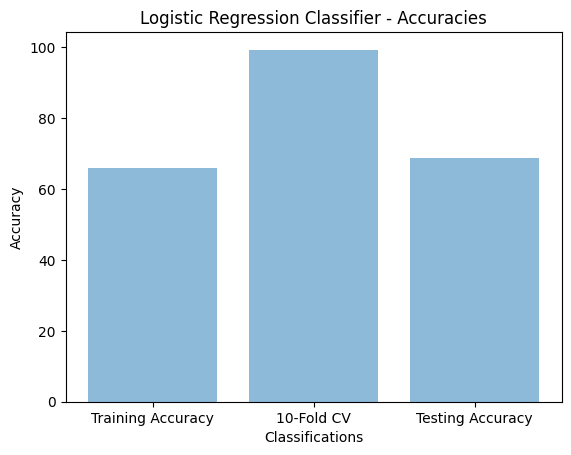

In [48]:
objects = ('Training Accuracy', '10-Fold CV', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_LG,avg_LG_kfold,accu_LG]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Classifier - Accuracies') 
plt.show()

### 5. Model Summary - Confusion matrix

In [49]:
metrics = MulticlassMetrics(labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))
# Model summary 
print("\nSummary Stats_LG\n")
labels = (sc.parallelize([row[0] for row in tshuff_rdd_test.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_LG = %s" % (label, metrics.precision(label)))
    print("Class %s recall_LG = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_NB = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))
# Model Weighted Stats 
print("\n\nAvg/Weighted recall_LG = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_LG = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_LG = %s" % metrics.weightedFMeasure())

cm=metrics.confusionMatrix().toArray()
print("\nConfusion matrix_LG=")
print(cm)
print("\n\n")

/content/spark-3.3.2-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Summary Stats_LG

Class 0 precision_LG = 0.8121904761904762
Class 0 recall_LG = 0.781238548919018
Class 0 F1 Measure_NB = 0.7964138961524095
Class 1 precision_LG = 0.4557477110885046
Class 1 recall_LG = 0.48484848484848486
Class 1 F1 Measure_NB = 0.4698479286837965
Class 2 precision_LG = 0.5398601398601398
Class 2 recall_LG = 0.5761194029850746
Class 2 F1 Measure_NB = 0.5574007220216606


Avg/Weighted recall_LG = 0.6860976173953273
Avg/Weighted precision_LG = 0.6937971289095262
Avg/Weighted F(1) Score_LG = 0.6895700884705682

Confusion matrix_LG=
[[2132.  402.  195.]
 [ 342.  448.  134.]
 [ 151.  133.  386.]]





### 6. ROC Curve and AUC

/content/spark-3.3.2-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Area under ROC_Logistic_Regression = 0.7469819720617761


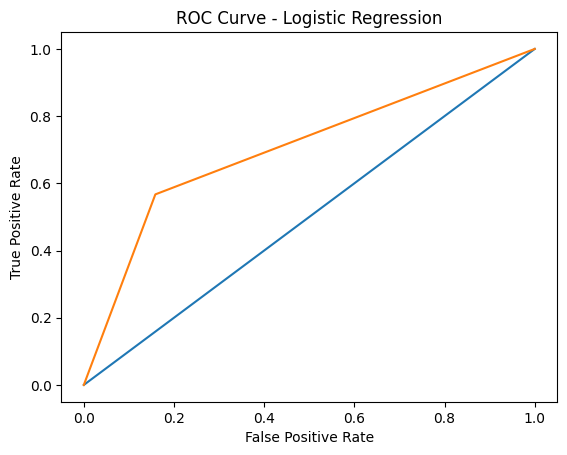

In [50]:
model_train_LG.setThreshold(0.25)
labels_and_preds_LG2,accu_LG2 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
model_train_LG.setThreshold(0.75)
labels_and_preds_LG3,accu_LG3 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
model_train_LG.setThreshold(0.1)
labels_and_preds_LG4,accu_LG4 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
model_train_LG.setThreshold(0.9)
labels_and_preds_LG5,accu_LG5 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)

tpr,fpr=tf(labels_and_preds_LG) 
tpr2,fpr2=tf(labels_and_preds_LG2) 
tpr3,fpr3=tf(labels_and_preds_LG3)
tpr4,fpr4=tf(labels_and_preds_LG4) 
tpr5,fpr5=tf(labels_and_preds_LG5) 

x = [0,fpr5,fpr3,fpr,fpr2,fpr4,1]
y = [0,tpr5,tpr3,tpr,tpr2,tpr4,1]

# This is the ROC curve
x1=[0,1]
y1=[0,1]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.plot(x1,y1)
plt.plot(x,y)

metrics2 = BinaryClassificationMetrics(labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))
model_train_LG.clearThreshold()
labels_and_probs_LG=test_wpp(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
metrics = MulticlassMetrics(labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))
# Area under ROC curve
print("Area under ROC_Logistic_Regression = %s" % metrics2.areaUnderROC)
plt.show()

## Applying Naive Bayes 


### 1. Training

In [51]:
%%time
#Accuracy of Training data using train.csv itself using NB
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_train=CompTFIDF(tf_train,idf_train)
#Feature Extraction\
training_NB = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
model_train_NB=NB_train(training_NB)
#testing NB with training data 
accuracy_NB=test(model_train_NB,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
print ("TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using NB is",accuracy_NB,"%")
print ("\n")

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using NB is 88.8176430583892 %


CPU times: user 579 ms, sys: 59.6 ms, total: 638 ms
Wall time: 8.45 s


### 2. Validation using K Fold Cross Validation

In [52]:
%%time
# KFold NB
print ("10-FOLD CV ACCURACIES FOR ALL ITERATIONS\n")
tot_NB_kfold=0
NB_kfold_set=[]
for i in range(0,len(p)):
    test_RDD=p[i]
    train_tempRDD=sc.emptyRDD()
    for j in range(0,len(p)):
        if i!=j:
            train_tempRDD=train_tempRDD.union(p[j])
    tf_train=CompTF(train_tempRDD)
    idf_train=CompIDF(tf_train)
    tfidf_train=CompTFIDF(tf_train,idf_train)
    training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in train_tempRDD.collect()]),tfidf_train)
    model_train=NB_train(training)
    tf_test=CompTF(test_RDD)
    tfidf_test=CompTFIDF(tf_test,idf_train)
    accuracy=test(model_train,sc.parallelize([row[0] for row in test_RDD.collect()]),tfidf_test)
    print ("The accuracy for number",i+1,"kth partition test for 10-fold cross validation for NB is",accuracy,"%")
    NB_kfold_set.append(accuracy)
    tot_NB_kfold=tot_NB_kfold+accuracy
avg_NB_kfold=tot_NB_kfold/len(p)
NB_kfold_best=max(NB_kfold_set)
print ("\n")
print ("The average accuracy for NB after 10-fold cross validation is",avg_NB_kfold,"%")
print ("\n")
print ("The highest accuracy for NB after 10-fold cross validation is",NB_kfold_best,"%")
print ("\n")

10-FOLD CV ACCURACIES FOR ALL ITERATIONS

The accuracy for number 1 kth partition test for 10-fold cross validation for NB is 75.85513078470825 %
The accuracy for number 2 kth partition test for 10-fold cross validation for NB is 73.25581395348837 %
The accuracy for number 3 kth partition test for 10-fold cross validation for NB is 72.92051756007393 %
The accuracy for number 4 kth partition test for 10-fold cross validation for NB is 74.01500938086303 %
The accuracy for number 5 kth partition test for 10-fold cross validation for NB is 73.7 %
The accuracy for number 6 kth partition test for 10-fold cross validation for NB is 72.04724409448819 %
The accuracy for number 7 kth partition test for 10-fold cross validation for NB is 70.5050505050505 %
The accuracy for number 8 kth partition test for 10-fold cross validation for NB is 73.25800376647834 %
The accuracy for number 9 kth partition test for 10-fold cross validation for NB is 74.42084942084942 %
The accuracy for number 10 kth parti

### 3. Testing the model on the test dataset.

In [53]:
%%time
#print (test_shuffle)
tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF(tshuff_rdd_test)
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)
labels_and_preds_NB,accu_NB = test_final(model_train_NB,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
print ("\nTEST ACCURACY:-\n")
print("The accuracy of prediction for NB on testing data is",accu_NB,"%")


TEST ACCURACY:-

The accuracy of prediction for NB on testing data is 74.50844321073329 %
CPU times: user 157 ms, sys: 14.5 ms, total: 171 ms
Wall time: 1.41 s


### 4. Ploting different accuracies

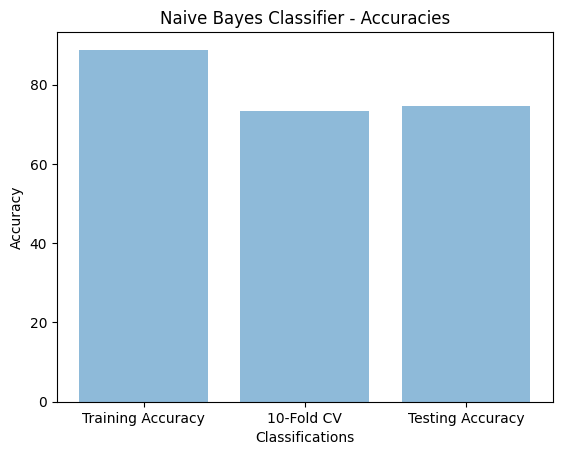

In [54]:
objects = ('Training Accuracy', '10-Fold CV', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_NB,avg_NB_kfold,accu_NB]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Classifier - Accuracies')
plt.show()

### 5. Model Summary - Confusion Matrix

In [55]:
metrics = MulticlassMetrics(labels_and_preds_NB.map(lambda x: (x["predicted"], x["actual"])))
# Overall statistics
print("\nSummary Stats_NB\n")
# Statistics by class
labels = (sc.parallelize([row[0] for row in tshuff_rdd_test.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_NB = %s " % (label, metrics.precision(label)))
    print("Class %s recall_NB = %s " % (label, metrics.recall(label)))
    print("Class %s F1 Measure_NB = %s \n" % (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\nAvg/Weighted recall_NB = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_NB = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_NB = %s" % metrics.weightedFMeasure())

cm=metrics.confusionMatrix().toArray()
print("\nConfusion matrix_NB=")
print(cm)
print("\n")


Summary Stats_NB

Class 0 precision_NB = 0.7761699507389163 
Class 0 recall_NB = 0.9237816049835105 
Class 0 F1 Measure_NB = 0.8435670068596285 

Class 1 precision_NB = 0.6358792184724689 
Class 1 recall_NB = 0.3874458874458874 
Class 1 F1 Measure_NB = 0.4815063887020847 

Class 2 precision_NB = 0.66796875 
Class 2 recall_NB = 0.5104477611940299 
Class 2 F1 Measure_NB = 0.5786802030456853 


Avg/Weighted recall_NB = 0.7450844321073329
Avg/Weighted precision_NB = 0.7294145861519925
Avg/Weighted F(1) Score_NB = 0.7251265327136852

Confusion matrix_NB=
[[2521.  132.   76.]
 [ 472.  358.   94.]
 [ 255.   73.  342.]]




### 6. ROC Curve and AUC

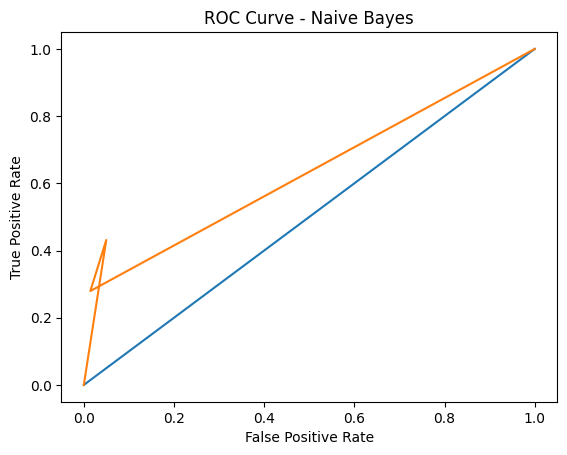

Area under ROC_NB = 0.7366982404243101


In [56]:
tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF(tshuff_rdd_test)
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)
labels_and_preds_NB2,accu_NB2 = test_final(model_train_NB,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tf_test)
tpr,fpr=tf(labels_and_preds_NB)
tpr2,fpr2=tf(labels_and_preds_NB2)
x = [0,fpr,fpr2,1]
y = [0,tpr,tpr2,1]
# This is the ROC curve
x1=[0,1]
y1=[0,1]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.plot(x1,y1)
plt.plot(x,y)
plt.show()
metrics2 = BinaryClassificationMetrics(labels_and_preds_NB.map(lambda x: (x["predicted"], x["actual"])))
# Area under ROC curve
print("Area under ROC_NB = %s" % metrics2.areaUnderROC)

## Applying Decision Tree

### 1. Training

In [57]:
%%time
#Accuracy of Training data using train.csv itself using DT
#print (test_shuffle)
tf_train=CompTF_withNumFeatures(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_train=CompTFIDF(tf_train,idf_train)
## features extractions
training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
model_train_DT=DT_train(training)
accuracy_DT=test(model_train_DT,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
print ("TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using DT is",accuracy_DT,"%")
print("\n")

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using DT is 68.69717283590789 %


CPU times: user 283 ms, sys: 30.9 ms, total: 313 ms
Wall time: 15.3 s


### 2. Validation using K Fold Cross Validation

In [58]:
%%time
# KFold DT
print ("10-FOLD CV ACCURACIES FOR ALL ITERATIONS\n")
tot_DT_kfold=0
DT_kfold_set=[]
for i in range(0,len(p)):
    test_RDD=p[i]
    train_tempRDD=sc.emptyRDD()
    for j in range(0,len(p)):
        if i!=j:
            train_tempRDD=train_tempRDD.union(p[j])
    tf_train=CompTF_withNumFeatures(train_tempRDD)
    idf_train=CompIDF(tf_train)
    tfidf_train=CompTFIDF(tf_train,idf_train)
    training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in train_tempRDD.collect()]),tfidf_train)
    model_train = DT_train(training)
    tf_test = CompTF_withNumFeatures(test_RDD)
    tfidf_test = CompTFIDF(tf_test,idf_train)
    accuracy=test(model_train,sc.parallelize([row[0] for row in test_RDD.collect()]),tfidf_test)
    print ("The accuracy for number",i+1,"kth partition test for 10-fold cross validation for DT is",accuracy,"%")
    tot_DT_kfold=tot_DT_kfold+accuracy
    DT_kfold_set.append(accuracy)
avg_DT_kfold=tot_DT_kfold/len(p)
DT_kfold_best=max(DT_kfold_set)
print("\n")
print ("The average accuracy for DT after 10-fold cross validation is",avg_DT_kfold,"%")
print("\n")
print ("The highest accuracy for DT after 10-fold cross validation is",DT_kfold_best,"%")
print("\n")

10-FOLD CV ACCURACIES FOR ALL ITERATIONS

The accuracy for number 1 kth partition test for 10-fold cross validation for DT is 68.2092555331992 %
The accuracy for number 2 kth partition test for 10-fold cross validation for DT is 69.28294573643412 %
The accuracy for number 3 kth partition test for 10-fold cross validation for DT is 67.8373382624769 %
The accuracy for number 4 kth partition test for 10-fold cross validation for DT is 70.26266416510319 %
The accuracy for number 5 kth partition test for 10-fold cross validation for DT is 67.0 %
The accuracy for number 6 kth partition test for 10-fold cross validation for DT is 67.71653543307087 %
The accuracy for number 7 kth partition test for 10-fold cross validation for DT is 67.77777777777779 %
The accuracy for number 8 kth partition test for 10-fold cross validation for DT is 69.9623352165725 %
The accuracy for number 9 kth partition test for 10-fold cross validation for DT is 67.56756756756756 %
The accuracy for number 10 kth partiti

### 3. Testing the model on the test dataset.

In [59]:
%%time
tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF_withNumFeatures(tshuff_rdd_test)
tf_train=CompTF_withNumFeatures(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)
labels_and_preds_DT,accu_DT = test_final(model_train_DT,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
print ("\nTEST ACCURACY:-\n")
print("The accuracy of prediction for DT on testing data is",accu_DT,"%")
print("\n")


TEST ACCURACY:-

The accuracy of prediction for DT on testing data is 69.18806384455239 %


CPU times: user 127 ms, sys: 9.47 ms, total: 136 ms
Wall time: 1.44 s


### 4. Ploting different accuracies


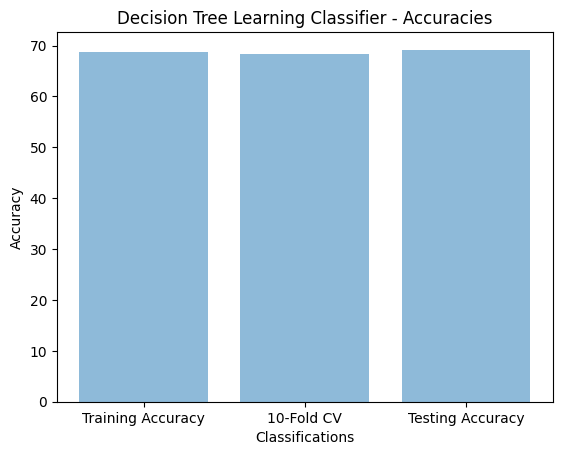

In [60]:
objects = ('Training Accuracy', '10-Fold CV', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_DT,avg_DT_kfold,accu_DT]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Decision Tree Learning Classifier - Accuracies') 
plt.show()


### 5. Model Summary - Confusion Matrix


In [61]:
metrics = MulticlassMetrics(labels_and_preds_DT.map(lambda x: (x["predicted"], x["actual"])))
# Overall statistics
print("\nSummary Stats_D\n")
# Statistics by class
labels = (sc.parallelize([row[0] for row in tshuff_rdd_test.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_DT = %s" % (label, metrics.precision(label)))
    print("Class %s recall_DT = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_DT = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\n\nAvg/Weighted recall_DT = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_DT = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_DT = %s" % metrics.weightedFMeasure())

cm=metrics.confusionMatrix().toArray()
print("\nConfusion matrix_DT=")
print(cm)


Summary Stats_D

Class 0 precision_DT = 0.7050930996714129
Class 0 recall_DT = 0.9435690729204836
Class 0 F1 Measure_DT = 0.8070835292273937
Class 1 precision_DT = 0.5296610169491526
Class 1 recall_DT = 0.13528138528138528
Class 1 F1 Measure_DT = 0.21551724137931033
Class 2 precision_DT = 0.6689655172413793
Class 2 recall_DT = 0.4343283582089552
Class 2 F1 Measure_DT = 0.5266968325791855


Avg/Weighted recall_DT = 0.6918806384455238
Avg/Weighted precision_DT = 0.6619969338922107
Avg/Weighted F(1) Score_DT = 0.6371861577895199

Confusion matrix_DT=
[[2575.   70.   84.]
 [ 739.  125.   60.]
 [ 338.   41.  291.]]


## Which is the Best Classifier?
The classifier with a better cross valiation score is the best.



In [62]:
maxi=max(float(avg_NB_kfold),float(avg_LG_kfold),float(avg_DT_kfold))
maxi_high=max(float(DT_kfold_best),float(LG_kfold_best),float(NB_kfold_best))
print ("Most accurate based on highest 10-fold CV accuracy:-\n")
if maxi_high==NB_kfold_best:
     print ("Naive Bayes is the most accurate Classifier\n")
elif maxi_high==LG_kfold_best:
    print ("Logistic Regression is the most accurate Classifier\n")
elif maxi_high==DT_kfold_best:
    print ("Decision Trees  is the most accurate Classifier\n")

Most accurate based on highest 10-fold CV accuracy:-

Logistic Regression is the most accurate Classifier



Fetching some of the Tweets after selecting the best classifer
Outputing the prediction probabilitioes and the corresponding tweet for Correctly and Incorrectly predicted label for tweets

In [63]:
 
print ("Most accurate based on average 10-fold CV accuracy:-\n")

if maxi==avg_NB_kfold:
    print ("NB is the most accurate Classifier")
    lpr= labels_and_preds_NB.map(lambda x:[x["predicted"],x["actual"]])
    lpr_list=[]
    for i in lpr.collect():
        lpr_list.append(i)
    print("******************************************************")
    print ("some test tweets that are classified correctly along with their prediction labels(NB):-\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]==lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("some test tweets that are classified incorrectly along with their prediction labels(NB):-\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]!=lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("Correctly classified tweets (5)(NB):-\n\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]==lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==5:
                break
    print("******************************************************")
    print ("Incorrectly classified tweets (5)(NB):-\n\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]!=lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==5:
                break
elif maxi==avg_LG_kfold:
    print ("LG is the most accurate Classifier")
    lp=labels_and_probs_LG.map(lambda x:[x["probs"],x["actual"]])
    lp_list=[]
    for i in lp.collect():
        lp_list.append(i)
    pred=labels_and_preds_LG.map(lambda x:x["predicted"])
    pred_list=[]
    for i in pred.collect():
        pred_list.append(i)
    print("******************************************************")
    print ("some test tweets that are classified correctly along with their prediction probabilities(LG):-\n")
    c=0
    for i in range(0,len(lp_list)):
        if lp_list[i][1]==pred_list[i]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction probability - ",lp_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("some test tweets that are classified incorreclty along with their prediction probabilities(LG):-\n")
    c=0
    for i in range(0,len(lp_list)):
        if lp_list[i][1]!=pred_list[i]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction probability - ",lp_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    corr_tw_lg=[]
    incorr_tw_lg=[]
    for i in range(0,len(lp_list)):
        if lp_list[i][1]==pred_list[i]:
            corr_tw_lg.append([lp_list[i][0],test_tweet_list[i]])
    for i in range(0,len(lp_list)):
        if lp_list[i][1]!=pred_list[i]:
            incorr_tw_lg.append([lp_list[i][0],test_tweet_list[i]])
    
    corr_tw_lg=sorted(corr_tw_lg,key=lambda l:l[0], reverse=True)
    incorr_tw_lg=sorted(incorr_tw_lg,key=lambda l:l[0], reverse=True)
    
    print("******************************************************")
    c=0
    print("Correctly classified tweets sorted by probabilities are (LG):-\n")
    for i in range(0,len(corr_tw_lg)):
        print(i+1,") tweet - ",corr_tw_lg[i][1])
        print("prediction probability - ",corr_tw_lg[i][0])
        print("\n")
        c=c+1
        if c==5:
            break
    print("******************************************************")
    c=0
    print("Incorrectly classified tweets sorted by probabilities are (LG):-")
    for i in range(0,len(corr_tw_lg)):
        print(i+1,") tweet - ",incorr_tw_lg[i][1])
        print ("prediction probability - ",incorr_tw_lg[i][0])
        print("\n")
        c=c+1
        if c==5:
            break
    
elif maxi==avg_DT_kfold:
    print ("DT is the most accurate Classifier")
    lpr= labels_and_preds_DT.map(lambda x:[x["predicted"],x["actual"]])
    lpr_list=[]
    for i in lpr.collect():
        lpr_list.append(i)
    print("******************************************************")
    print ("some test tweets that are classified correctly along with their prediction labels(DT):-\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]==lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("some test tweets that are classified incorrectly along with their prediction labels(DT):-\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]!=lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("Correctly classified tweets (5)(DT):-\n\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]==lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==5:
                break
    print("******************************************************")
    print ("Incorrectly classified tweets (5)(DT):-\n\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]!=lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==5:
                break
    
else:
    print ("Error Occured")

Most accurate based on average 10-fold CV accuracy:-

LG is the most accurate Classifier
******************************************************
some test tweets that are classified correctly along with their prediction probabilities(LG):-

1 ) tweet -  \.@united It's worth saying that
prediction probability -  0.0


2 ) tweet -  \@AmericanAir \"\"sorry you were disappointed\"\" #outoftouchwithreality #people have kids and jobs\""
prediction probability -  0.0


3 ) tweet -  \@AmericanAir $600 Late Flightr
prediction probability -  0.0


4 ) tweet -  \@AmericanAir @USAirways \"\"ma'am if you have a complaint you should visit our customer service desk\"\" {sees line ~45 people deep}\""
prediction probability -  0.0


5 ) tweet -  \@AmericanAir @emxlyy \"\"The wheel was broken when we got it. We swear.\"\"\""
prediction probability -  0.0


7 ) tweet -  \@AmericanAir AA agent said I repeated myself when I was explaining. I told him \"\"I understand English.\"\" His reply?\"\"Our conversat